In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import tensorflow as tf
import time

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import numpy as np
import time
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

#resize and black pad images to 224x224 with no distortion
def cleaner(file):
    #resize image while keeping aspect ratio (e.g. 500x375 becomes 224x168)
    x = 224
    y = 224
    image = Image.open(file).convert("RGB")
    image.thumbnail((x, y), Image.ANTIALIAS)

    #add symmetrical black padding to the smaller dimension to match the desired x and y
    deltaX = x - image.size[0]
    deltaY = y - image.size[1]
    padding = (deltaX//2, deltaY//2, deltaX-(deltaX//2), deltaY-(deltaY//2))

    return ImageOps.expand(image, padding)

#load images from Google Drive
def loadImages(folder):
    #transform to tensor and normalize
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

    #load data from Google Drive and clean them as they load
    dataset = torchvision.datasets.ImageFolder(root=folder, loader=cleaner, transform=transform)
    
    return dataset

#verify that the images have been loaded and labeled
def verifyImages(dataset):
    #prepare dataloader
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1, shuffle=True)

    #verification step - obtain one batch of images
    dataiter = iter(dataLoader)
    images, labels = dataiter.next()
    images = images.numpy() #convert images to numpy for display
    classes = ["Not Rainy", "Rainy"]

    #plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(6):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture = np.transpose(images[idx], (1, 2, 0))
        picture = std * picture + mean
        picture = np.clip(picture, 0, 1)
        plt.imshow(picture)
        ax.set_title(classes[labels[idx]])

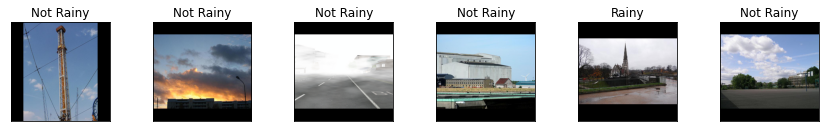

In [0]:
#example usage with folder named "Overfit"
#within the folder "Overfit" there are two subfolders named "NotSnow" and "Snow"
#the subfolder name which is alphabetically first will be labelled as class 0
#the second folder will be labelled as class 1
data = loadImages("/content/gdrive/My Drive/APS360_Project/RainNet50")
verifyImages(data)

In [0]:
#DO NOT RUN THIS!!!
data.__getitem__(18600)[1]
zero_index = 5085
one_index = 15198
two_index = 16700
three_index = 0
four_index = 0
for index in range(16700, 18603):
  if (data.__getitem__(index)[1] == 2):
    two_index+=1
  if (data.__getitem__(index)[1] == 3):
    three_index+=1
  if (data.__getitem__(index)[1] == 4):
    four_index+=1
three_index = three_index + two_index
four_index = four_index + three_index
print(zero_index)
print(one_index)
print(two_index)
print(three_index)
print(four_index)
#End of do not run

In [0]:
#train-val-test split
#Class 0 from 0-5085
#Class 1 from 5085-15198
#Class 2 from 15198-16781
#Class 3 from 16781-18033
#Class 4 from 18033-18603
batch_size=32
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
indices=np.arange(3208)
indices = np.delete(indices,3115,0)
np.random.shuffle(indices)
split = int(len(data) * 0.6)
split2=int(len(data)*0.2)
indices.size
train_indices, val_indices, test_indices = indices[:split], indices[split:split+split2], indices[split+split2:]
train_sampler = SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                              num_workers=1, sampler=test_sampler)

In [0]:
# resnet
import torchvision.models

resNet = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

torch.__version__
#!pip install -q torch==0.4.1 torchvision

import torchvision
torchvision.__version__  # should be 0.2.1
input_path = "/content/gdrive/My Drive/APS360_Project/data"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 32),#3208
               nn.ReLU(inplace=True),
               nn.Linear(32, 2)).to(device)
               #nn.Linear(32, 2))

In [0]:
#Generate a name for the model consisting of all the hyperparameter values
def get_model_name(size=320, batchSize=500, learningRate=0.0008, epoch=29):
    return "/content/gdrive/My Drive/APS360_Project/RainNet/Models/size{0}_bs{1}_lr{2}_epoch{3}".format(size, batchSize, learningRate, epoch)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [0]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
def train(model, train_loader, val_loader, batch_size=27, num_epochs=1, learn_rate = 0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    epochs, losses, train_acc, val_acc, iters = [], [], [], [], []

    # training
    print ("Training Started...")
    n = 0 # the number of iterations
    start_time = time.time()
    for epoch in range(num_epochs):
        epochs.append(epoch)
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            iters.append(n) #Keep track of iterations
            n += 1       
        
        # track accuracy
        train_acc.append(get_accuracy(model, train=True))
        val_acc.append(get_accuracy(model, train=False))
        losses.append(loss)
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_acc[-1]))
        
##################################################################
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(batch_size, learn_rate, num_epochs)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_losses.csv".format(model_path), losses)
####################################################################
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return train_acc, val_acc, iters

In [0]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model, train_loader, val_loader, batch_size=27, num_epochs=5, learn_rate = 0.01)


In [0]:
model1 = models.resnet50(pretrained=True).to(device)
    
for param in model1.parameters():
    param.requires_grad = False   
    
model1.fc = nn.Sequential(
               nn.Linear(2048, 1000),#3208
               nn.ReLU(inplace=True),
               nn.Linear(1000, 2)).to(device)
               #nn.Linear(32, 2))

In [0]:
#from ImageCleaning import *

#using the trained neural network, evaluate its performance on a data set

def eval(model, test_loader, batch_size=27, num_epochs=1, learn_rate = 0.01):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    totalLoss = 0
    totalAcc = 0
    total0Acc = 0
    total1Acc = 0
    total0 = 0
    total1 = 0
    totalEpoch = 0

    epochs, losses, train_acc, val_acc, iters = [], [], [], [], []

    for imgs, labels in iter(test_loader):
            
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

        out = model(imgs)             # forward pass
        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch
        iters.append(n) #Keep track of iterations
        n += 1    
        classes = ["Not Rainy", "Rainy"]
        #plot the pictures, labels and if the model got it right
        fig = plt.figure(figsize=(25,  4 * (len(labels)//10+1)))
        for idx in range(len(labels)):
          ax = fig.add_subplot(len(labels)//10+1, 10, idx+1, xticks=[], yticks=[])
          mean = np.array([0.485, 0.456, 0.406])
          std = np.array([0.229, 0.224, 0.225])
          picture = np.transpose(images[idx], (1, 2, 0))
          picture = std * picture + mean
          picture = np.clip(picture, 0, 1)
          plt.imshow(picture)
          guess = int(outputs.squeeze()[idx].item() > 0)
          if guess == labels[idx].item():
            isCorrect = ' O'
          else:
            isCorrect = ' X'
          ax.set_title(classes[labels[idx].item()] + isCorrect)
def evaluate(net, loader, criterion=nn.BCEWithLogitsLoss(), testing=False, showImages=False):
  totalLoss = 0
  totalAcc = 0
  total0Acc = 0
  total1Acc = 0
  total0 = 0
  total1 = 0
  totalEpoch = 0

  for i, data in enumerate(loader, 0):
      #get the inputs
      inputs, labels = data

      if showImages:
          images = inputs.numpy() #convert images to numpy for display
        
      if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

      #get the predictions
      outputs = net(inputs)

      #evaluate the loss and accuracy
      loss = criterion(outputs, labels.float())
      cacc = (outputs > 0).squeeze().long() == labels
        
      #evaluate true positives and true negatives
      cfalse = 0
      ctrue = 0
      if testing:
          for i, output in enumerate(outputs.squeeze(), 0):
              if labels[i].item() == 0:
                  total0 += 1
                  if output.item() <= 0:
                      cfalse += 1
              elif labels[i].item() == 1:
                  total1 += 1
                  if output.item() > 0:
                      ctrue += 1

      totalAcc += int(cacc.sum())
      totalLoss += loss.item()
      totalEpoch += len(labels)
      total0Acc += cfalse
      total1Acc += ctrue
        
      #print the images, their labels and whether the model was correct or not
      if showImages:
          classes = ["Not Rainy", "Rainy"]
          #plot the pictures, labels and if the model got it right
          fig = plt.figure(figsize=(25,  4 * (len(labels)//10+1)))
          for idx in range(len(labels)):
              ax = fig.add_subplot(len(labels)//10+1, 10, idx+1, xticks=[], yticks=[])
              mean = np.array([0.485, 0.456, 0.406])
              std = np.array([0.229, 0.224, 0.225])
              picture = np.transpose(images[idx], (1, 2, 0))
              picture = std * picture + mean
              picture = np.clip(picture, 0, 1)
              plt.imshow(picture)
              guess = int(outputs.squeeze()[idx].item() > 0)
              
              if guess == labels[idx].item():
                  isCorrect = ' O'
              else:
                  isCorrect = ' X'
              #ax.set_title(classes[labels[idx].item()] + isCorrect)
    
    #calculate the final accuracy and loss
    #acc = float(totalAcc) / totalEpoch
    #loss = float(totalLoss) / (i + 1)
    #if not testing:
     #   return acc, loss
    #else:
     #   return acc, total0Acc / total0, total1Acc / total1

#example of usage
#IMPORTANT: if you saved ResNet50 features to Google Drive
#you have to load IMAGES instead of those features and feed it to
#resnet50, then to the rest of your model's layers

#Generate a name for the model consisting of all the hyperparameter values
def getModelName(batchSize=32, learningRate=0.0001, epoch=30):
    return "/content/gdrive/My Drive/APS360_Project/RainData".format(batchSize, learningRate, epoch)
    
batchSize = 32
learningRate = 0.0001
epoch = 30

#if torch.cuda.is_available():
 #   model = model.cuda()
#model.load_state_dict(torch.load(getModelName(batchSize, learningRate, epoch)))

#imagePath = "/content/gdrive/My Drive/APS360_Project/RainData"
#testLoader = torch.utils.data.DataLoader(testingImages, batch_size=batchSize, num_workers=1, shuffle=True)

#acc, acc0, acc1 = evaluate(model, testLoader, nn.BCEWithLogitsLoss(), True, True)
#print(acc)
#print(acc0)
#print(acc1)

CUDA is available!  Training on GPU ...
Training Started...
Epoch 1; Loss 0.781498; Train Acc 0.812370; Val Acc 0.794072
Epoch 2; Loss 0.661759; Train Acc 0.822245; Val Acc 0.784711
Epoch 3; Loss 0.752433; Train Acc 0.839397; Val Acc 0.794072
Epoch 4; Loss 0.194875; Train Acc 0.832121; Val Acc 0.784711
Epoch 5; Loss 0.279862; Train Acc 0.848233; Val Acc 0.790952
Epoch 7; Loss 0.611213; Train Acc 0.852911; Val Acc 0.781591
Epoch 8; Loss 0.363272; Train Acc 0.846674; Val Acc 0.806552
Epoch 9; Loss 0.711378; Train Acc 0.876299; Val Acc 0.809672
Epoch 10; Loss 0.761372; Train Acc 0.868503; Val Acc 0.814353
Epoch 11; Loss 0.317868; Train Acc 0.832640; Val Acc 0.790952
Epoch 12; Loss 0.452701; Train Acc 0.879418; Val Acc 0.797192
Epoch 13; Loss 0.120003; Train Acc 0.876299; Val Acc 0.790952
Epoch 14; Loss 0.846965; Train Acc 0.884096; Val Acc 0.811232
Epoch 15; Loss 0.305316; Train Acc 0.886694; Val Acc 0.833073
Epoch 16; Loss 0.413464; Train Acc 0.898129; Val Acc 0.815913
Epoch 17; Loss 1.2

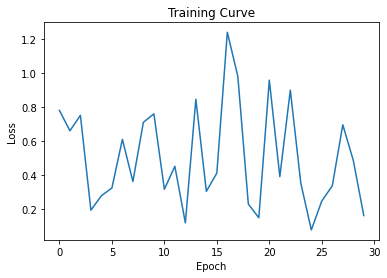

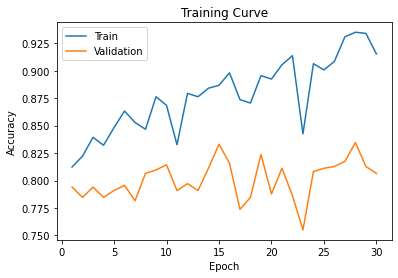

([0.8123700623700624,
  0.8222453222453222,
  0.8393970893970893,
  0.8321205821205822,
  0.8482328482328483,
  0.8633056133056133,
  0.8529106029106029,
  0.8466735966735967,
  0.8762993762993763,
  0.8685031185031185,
  0.8326403326403327,
  0.8794178794178794,
  0.8762993762993763,
  0.8840956340956341,
  0.8866943866943867,
  0.8981288981288982,
  0.8737006237006237,
  0.8705821205821206,
  0.8955301455301455,
  0.8924116424116424,
  0.9054054054054054,
  0.9137214137214137,
  0.8425155925155925,
  0.9064449064449065,
  0.9007276507276507,
  0.9085239085239085,
  0.9308731808731808,
  0.935031185031185,
  0.933991683991684,
  0.9152806652806653],
 [0.7940717628705148,
  0.7847113884555382,
  0.7940717628705148,
  0.7847113884555382,
  0.7909516380655226,
  0.7956318252730109,
  0.781591263650546,
  0.8065522620904836,
  0.8096723868954758,
  0.8143525741029641,
  0.7909516380655226,
  0.797191887675507,
  0.7909516380655226,
  0.8112324492979719,
  0.8330733229329174,
  0.815912636

In [0]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train(model1, train_loader, val_loader, batch_size=32, num_epochs=30, learn_rate = 0.0001)

In [0]:
get_accuracy(model1, test_loader)

0.9095634095634095